In [43]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns

In [53]:
TRAINING_DATA_PATH = '/scratch/data/TrojAI/round7-train-dataset/'

def get_metadata():
    metadata = pd.read_csv(join(TRAINING_DATA_PATH, 'METADATA.csv'))
    return metadata

def id_str_to_model_id(id_str):
    id_str = str(100000000 + int(id_str))[1:]
    model_id = 'id-'+id_str
    return model_id

def get_all_files(path='results'):
    df_list = []
    files = [f for f in os.listdir(path)]
    for f in files:
        temp_df = pd.read_csv(join(path, f))
        temp_df['model_name'] = id_str_to_model_id(f[:-4])
        df_list.append(temp_df)
    result = pd.concat(df_list)
    return result[['source_class', 'target_class', 'decoded_top_candidate', 
                   'trigger_asr', 'loss', 'model_name']]

df = get_all_files()
metadata = get_metadata()

df_original_merged = df.merge(metadata, how='left', on='model_name')

plot_df = df.merge(metadata, how='left', on='model_name')
plot_df = plot_df[plot_df['trigger_asr']>.9]
plot_df = plot_df[plot_df['loss']<.2]
plot_df_temp = df.groupby(['model_name']).agg({'loss':'min'})
plot_df = plot_df_temp.merge(plot_df, on=['model_name', 'loss'], how='left')
plot_df


,model_name,loss,source_class,target_class,decoded_top_candidate,trigger_asr,poisoned,master_seed,lr_scheduler_level,lr_scheduler,...,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
0,id-00000000,2.241572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id-00000001,1.921139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id-00000002,1.978306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,id-00000003,3.084214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id-00000004,0.087980,1.0,7.0,frantic frantic,1.0,True,5.781110e+08,0.0,CyclicLR,...,None,None,None,None,None,0.849142,0.893802,0.9271944600411755,0.9050839552238806,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,id-00000087,0.043022,3.0,7.0,##rgeon lively,1.0,True,1.417039e+09,1.0,WarmupWithLinear,...,None,None,None,None,None,0.918369,0.938157,0.9900110987791344,0.9557625145518045,1.0
88,id-00000089,2.936999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,id-00000091,1.780097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,id-00000094,2.655336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='trigger_asr', ylabel='loss'>

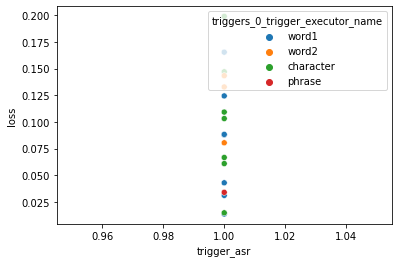

In [54]:
sns.scatterplot(data=plot_df, x='trigger_asr', y='loss', hue='triggers_0_trigger_executor_name')

In [55]:
lst=['poisoned', 'triggers_0_trigger_executor_name']
plot_df[list(df.columns)+lst].groupby(lst).agg({'model_name':'count'})

model_name
poisoned triggers_0_trigger_executor_name            
True     character                                  7
         phrase                                     1
         word1                                      7
         word2                                      3

In [56]:

df_original_merged[list(df.columns)+lst].groupby(['model_name', 'triggers_0_trigger_executor_name', 'poisoned'], as_index=False).count().groupby(lst).agg({'model_name':'count'})

model_name
poisoned triggers_0_trigger_executor_name            
False    None                                      42
True     character                                 13
         phrase                                    11
         word1                                     15
         word2                                     11

In [48]:
metadata.triggers_0_trigger_executor_name

0        None
1        None
2        None
3       word1
4       word1
        ...  
187      None
188    phrase
189      None
190     word1
191      None
Name: triggers_0_trigger_executor_name, Length: 192, dtype: object